<a href="https://colab.research.google.com/github/animeqvin/Clothes_Classification/blob/main/Clothes_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
len(train_data), len(test_data)

In [ ]:
image, label=train_data[0]
image, label


In [ ]:
class_names=train_data.classes
class_names

In [ ]:
class_to_idx=train_data.class_to_idx
class_to_idx

In [ ]:
image, label=train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis=(False);


In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis=False;

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis="Off";
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [ ]:
flatten_model = nn.Flatten()
x = train_features_batch[0]


output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")



In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0.to("cpu")

In [ ]:
dummy_x=torch.rand([1,1,28,28])
model_0(dummy_x)

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
start_time=timer()
end_time=timer()
print_train_time(start=start_time,
                 end=end_time,
                 device="cpu")

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0

    for batch, (x, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(x)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    if batch%400==0:
     print(f"looked at{batch*len(x)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    test_loss, test_acc=0,0
    model_0.eval()
    with torch.inference_mode():
     for x, y in test_dataloader:
       test_pred=model_0(x)
       test_loss += loss_fn(test_pred, y)
       test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
     test_loss/=len(test_dataloader)
     print(f"\nTrain loss: {train_loss:.4f} | test loss {test_loss:.4f} | test acc {test_acc:.2f}")
train_time_end_on_cpu=timer()
total_train_time_model_0=print_train_time(start=train_time_start_on_cpu,
                                              end=train_time_end_on_cpu,
                                              device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------

Train loss: 0.5904 | test loss 0.5095 | test acc 25678.12
Epoch: 1
-------

Train loss: 0.4763 | test loss 0.4799 | test acc 26040.62
Epoch: 2
-------

Train loss: 0.4550 | test loss 0.4766 | test acc 26112.50
Train time on cpu: 29.338 seconds


In [ ]:
str(next(model_0.parameters()).device)

'cpu'

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda: 28.402 seconds


In [ ]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
total_train_time_model_0

29.338276499999893

In [ ]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2


FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
model_2= FashionMNISTModelV2(input_shape=1,
                        hidden_units=10,
                        output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

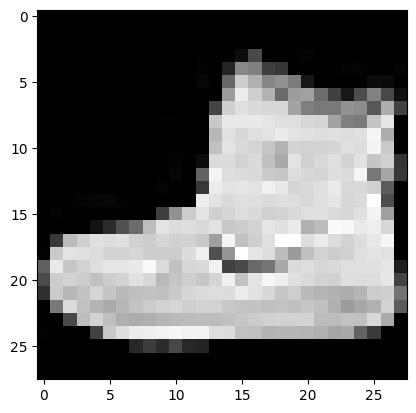

In [ ]:
plt.imshow(image.squeeze(), cmap="gray" )

In [ ]:
rand_image_tensor=torch.randn(size=(1, 28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
model_2(rand_image_tensor.unsqueeze(dim=0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [ ]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_layer(test_image)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [ ]:
test_image.unsqueeze(dim=0).shape
conv_layer(test_image.unsqueeze(dim=0)).shape
torch.manual_seed(42)
conv_layer_2 = nn.Conv2d(in_channels=3,
                         out_channels=10,
                         kernel_size=(5, 5),
                         stride=2,
                         padding=0)

conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [ ]:
print(f"test image org shape: {test_image.shape}")
print(f"test image unsqueezed shape: {test_image.unsqueeze(0).shape}")
max_pool_layer=nn.MaxPool2d(kernel_size=2)
test_image_through_conv=conv_layer(test_image.unsqueeze(dim=0))
print(f"test image after going through conv_layer: {test_image_through_conv.shape}")
test_image_through_conv_and_max_pool=max_pool_layer(test_image_through_conv)
print(f"shapeee: {test_image_through_conv_and_max_pool.shape} ")

print(conv_layer_2.state_dict())

test image org shape: torch.Size([3, 64, 64])
test image unsqueezed shape: torch.Size([1, 3, 64, 64])
test image after going through conv_layer: torch.Size([1, 10, 62, 62])
shapeee: torch.Size([1, 10, 31, 31]) 
OrderedDict([('weight', tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241, 

In [ ]:
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [ ]:
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")


max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.1)

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58819 | Train accuracy: 78.68%
Test loss: 0.39322 | Test accuracy: 85.73%

Epoch: 1
---------
Train loss: 0.36474 | Train accuracy: 86.80%
Test loss: 0.34877 | Test accuracy: 87.45%

Epoch: 2
---------
Train loss: 0.32760 | Train accuracy: 88.17%
Test loss: 0.33476 | Test accuracy: 87.71%

Train time on cuda: 34.309 seconds


In [ ]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33476272225379944,
 'model_acc': 87.70966453674122}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results


,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.334763,87.709665


In [ ]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,29.338276
1,FashionMNISTModelV1,0.685001,75.019968,28.401565
2,FashionMNISTModelV2,0.334763,87.709665,34.308538


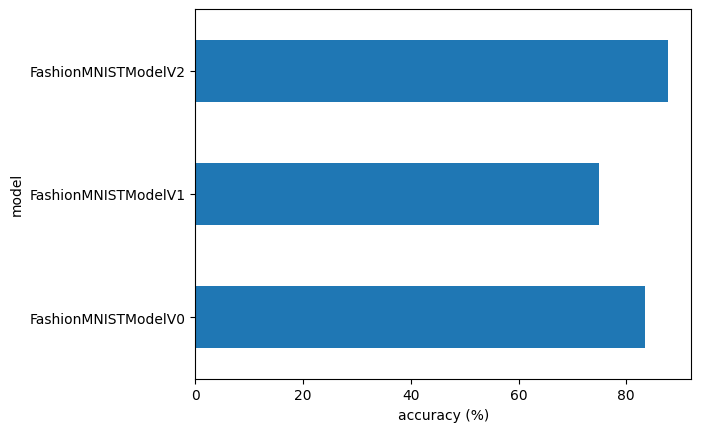

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [ ]:
def make_predictions(model:torch.nn.Module,
              data:list,
              device: torch.device=device):
  pred_probs=[]
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for sample in data:
      sample=torch.unsqueeze(sample, dim=0).to(device)
      pred_logit=model(sample)
      pred_prob=torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples=[]
test_labels=[]
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

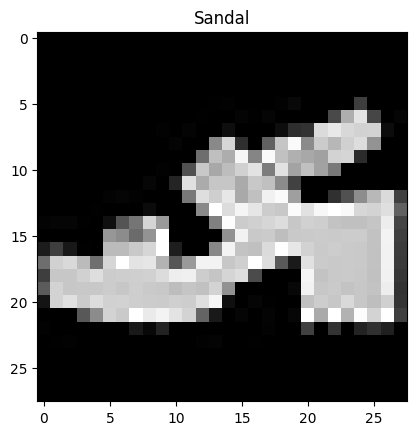

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
pred_probs=make_predictions(model=model_2,
                            data=test_samples)
pred_probs[:2]

tensor([[7.9644e-09, 6.8358e-11, 3.2319e-10, 1.3894e-08, 1.8191e-10, 1.0000e+00,
         1.2134e-08, 1.7409e-06, 1.3838e-06, 1.2185e-06],
        [6.7484e-02, 6.3462e-01, 8.4838e-04, 6.6185e-02, 7.4658e-02, 2.4901e-05,
         1.5555e-01, 2.9160e-04, 2.5994e-04, 8.4803e-05]])

In [ ]:
pred_classes=pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

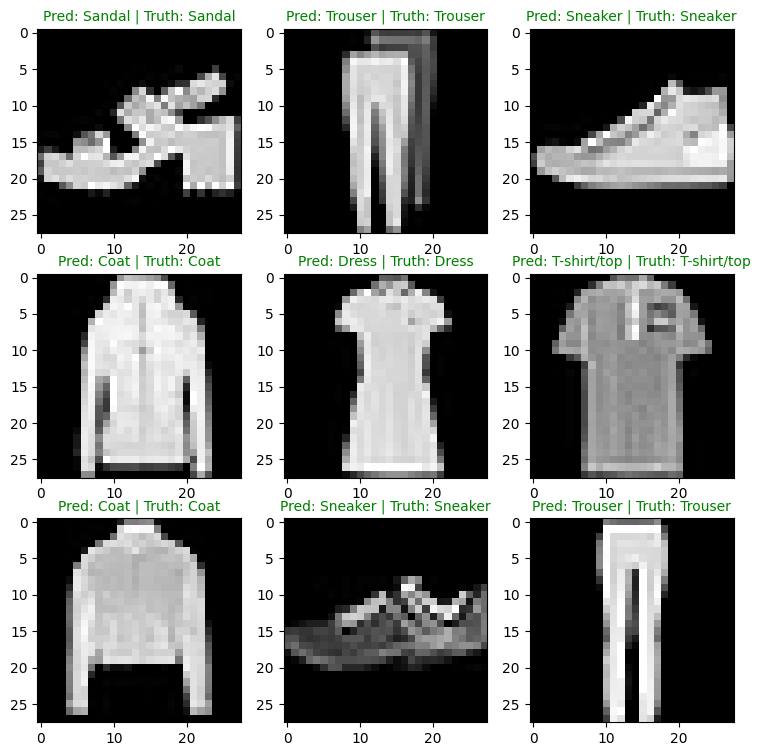

In [ ]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label=class_names[pred_classes[i]]
  truth_label=class_names[test_labels[i]]
  title_text=f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);


In [ ]:
!nvidia-smi

Sat May  3 17:08:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             29W /   70W |     166MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import mlxtend
mlxtend.__version__

'0.23.4'

In [ ]:
from tqdm.auto import tqdm
y_preds=[]
model_2.eval()
with torch.inference_mode():
  for x, y in tqdm(test_dataloader,
                   desc="making predictions..."):
    x, y=x.to(device), y.to(device)
    y_logit= model_2(x)
    y_pred=torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
print(y_preds)
y_pred_tensor=torch.cat(y_preds)
y_pred_tensor[:10]


making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 7, 7, 5,
        1, 6, 6, 3, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 4, 6, 6, 2, 5, 6, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 3, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 8]), tensor([6, 1, 6, 2, 3, 6, 7, 6, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 4, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 6, 2, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([7, 2, 3, 8, 0, 9, 4, 7, 4, 2, 6, 5, 6, 1, 2, 1, 3, 6, 8, 1, 0, 9, 3, 8,
        7, 9, 9, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 6, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 6, 4, 3, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 3, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 4, 9, 2, 2, 8, 6, 4,
        3, 4, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4,
       

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"torchmetrics version: {torchmetrics.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

torchmetrics version: 1.7.1


In [ ]:
assert int(mlxtend.__version__.split(".")[1]) >=19, "higher"

In [ ]:
import mlxtend
mlxtend.__version__

'0.23.4'

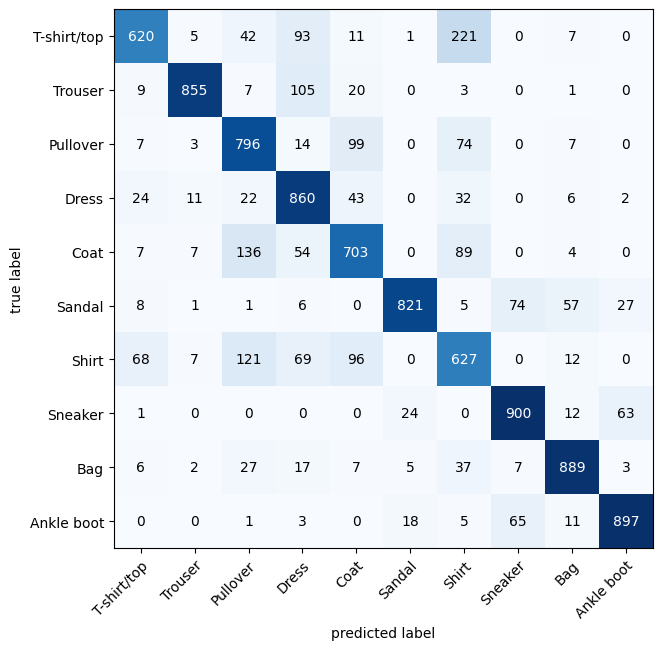

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
num_classes=len(class_names)
task="multiclass" if num_classes >2  else "binary"
confmat= ConfusionMatrix(num_classes=num_classes, task=task)
confmat_tensor=confmat(preds=y_pred_tensor,
                       target=test_data.targets)
fig, ax=plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)


In [ ]:
confmat_tensor

tensor([[620,   5,  42,  93,  11,   1, 221,   0,   7,   0],
        [  9, 855,   7, 105,  20,   0,   3,   0,   1,   0],
        [  7,   3, 796,  14,  99,   0,  74,   0,   7,   0],
        [ 24,  11,  22, 860,  43,   0,  32,   0,   6,   2],
        [  7,   7, 136,  54, 703,   0,  89,   0,   4,   0],
        [  8,   1,   1,   6,   0, 821,   5,  74,  57,  27],
        [ 68,   7, 121,  69,  96,   0, 627,   0,  12,   0],
        [  1,   0,   0,   0,   0,  24,   0, 900,  12,  63],
        [  6,   2,  27,  17,   7,   5,  37,   7, 889,   3],
        [  0,   0,   1,   3,   0,  18,   5,  65,  11, 897]])

In [ ]:
from pathlib import Path
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME= "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH= MODEL_PATH/MODEL_NAME
print(f"SAVING MODEL TO: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)


SAVING MODEL TO: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
torch.manual_seed(42)
loaded_model_2=FashionMNISTModelV2(input_shape=1,
                                   hidden_units=10,
                                   output_shape=len(class_names))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33476272225379944,
 'model_acc': 87.70966453674122}

In [ ]:
loaded_model_2_results=eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33476272225379944,
 'model_acc': 87.70966453674122}

In [ ]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-2)



tensor(True)

In [ ]:
from google.colab import files
files.download('helper_functions.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>